# Importing libraries

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from numpy import argmax
from sklearn import metrics  
from sklearn.tree import plot_tree
from sklearn import tree
from scipy.stats import randint
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV

# Importing data

In [55]:
path = r'C:\Users\thoma\OneDrive\Dokumente\data analytics\ML_Ach\ClimateWins'

In [56]:
path

'C:\\Users\\thoma\\OneDrive\\Dokumente\\data analytics\\ML_Ach\\ClimateWins'

In [57]:
Weather2 = pd.read_csv(os.path.join(path, 'Data', 'Prepared Data', 'Weather_NOTclean.csv'))
Pleasant_weather = pd.read_pickle(os.path.join(path, 'Data', 'Prepared Data', 'Pleasant_weather.pkl'))

In [58]:
# Dropping 'Unnamed: 0' column
Weather2 = Weather2.drop(['Unnamed: 0'], axis=1)

In [59]:
Weather2.shape

(22950, 150)

In [60]:
Pleasant_weather.shape

(22950, 15)

# Subsetting to 2000-2009

In [61]:
# Subsetting and filtering for decade
Weather2['DATE'] = pd.to_datetime(Weather2['DATE'])
Weather_sub2 = Weather2[(Weather2['DATE'].dt.year >= 2000) & (Weather2['DATE'].dt.year <= 2009)]

In [62]:
Weather_sub2.shape

(3653, 150)

In [63]:
# Dropping 'DATE', 'MONTH' & 'YEAR' columns
Weather_sub2 = Weather_sub2.drop(columns=['DATE', 'MONTH', 'YEAR'], errors='ignore')

In [64]:
# Filling in the missing values
Weather_sub2['KASSEL_cloud_cover'] = Weather_sub2['LJUBLJANA_cloud_cover']
Weather_sub2['MUNCHENB_pressure'] = Weather_sub2['SONNBLICK_pressure']
Weather_sub2['STOCKHOLM_humidity'] = Weather_sub2['OSLO_humidity']

In [65]:
# Observation type counts
Weather_sub2.columns.str.split('_', n=1).str[1].value_counts()

cloud_cover         15
humidity            15
pressure            15
global_radiation    15
precipitation       15
sunshine            15
temp_mean           15
temp_min            15
temp_max            15
wind_speed           9
snow_depth           6
Name: count, dtype: int64

In [66]:
# Dropping the 2 widely missing observation types
Weather_sub2 = Weather_sub2.drop(columns=Weather_sub2.filter(regex=r'_(wind_speed|snow_depth)$').columns)

In [67]:
# Observation type counts
Weather_sub2.columns.str.split('_', n=1).str[1].value_counts()

cloud_cover         15
humidity            15
pressure            15
global_radiation    15
precipitation       15
sunshine            15
temp_mean           15
temp_min            15
temp_max            15
Name: count, dtype: int64

In [68]:
Weather_sub2.shape

(3653, 135)

In [69]:
# Creating a NumPy array for X
X = Weather_sub2.to_numpy()
X.shape

(3653, 135)

In [70]:
# Creating a NumPy array for y
y = Pleasant_weather.to_numpy()
y.shape

(22950, 15)

# Subsetting the labels data set

In [71]:
# Adding 'DATE' to labels
Pleasant_weather['DATE'] = Weather2['DATE'].values

In [72]:
Pleasant_weather.shape

(22950, 16)

In [73]:
# Subsetting labels
Labels2 = Pleasant_weather[(Pleasant_weather['DATE'].dt.year >= 2000) & (Pleasant_weather['DATE'].dt.year <= 2009)]

In [74]:
Labels2.shape

(3653, 16)

In [75]:
# Dropping 'DATE'
Labels2 = Labels2.drop(columns=['DATE'], errors='ignore')

In [76]:
Labels2.shape

(3653, 15)

In [77]:
# Creating a NumPy array for y
y = Labels2.to_numpy()
y.shape

(3653, 15)

In [78]:
# Using argmax to get rid of one-hot encoding
y = np.argmax(y, axis = 1)
print(y.shape)
y

(3653,)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [79]:
# Splitting the data, while preserving the temporal aspect/dependancy by 'not shuffling'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# RANDOM SEARCH OPTIMIZATION

In [80]:
# Creating a RF classifier
clf = RandomForestClassifier(random_state=42)

In [81]:
# Random search cv
rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':randint(1,7),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)}

In [82]:
tscv = TimeSeriesSplit(n_splits=3)

In [83]:
pd.Series(y_train).value_counts()

0     1858
1      589
9      201
2      113
3       51
5       43
7       29
4       16
6        8
10       5
11       4
14       2
8        2
13       1
Name: count, dtype: int64

In [84]:
# Using scoring='balanced_accuracy'
start = time.time()
rf_random = RandomizedSearchCV(clf, rs_space, n_iter=100, scoring='balanced_accuracy', verbose=3, n_jobs=-1, cv=tscv,
    random_state=42)
model_random = rf_random.fit(X_train, y_train)
print('Search took %s minutes' % ((time.time() - start)/60))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Search took 2.1867988228797914 minutes


In [85]:
# Random search results
print('Best RANDOM search hyperparameters are: '+str(model_random.best_params_))
print('Best RANDOM search score is: '+str(model_random.best_score_))

Best RANDOM search hyperparameters are: {'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 460}
Best RANDOM search score is: 0.2258934953234787


In [86]:
# Using scoring='accuracy'
start = time.time()
rf_random_acc = RandomizedSearchCV(clf, rs_space, n_iter=100, scoring='accuracy', cv=tscv, n_jobs=-1, verbose=0, random_state=42)
model_random_acc = rf_random_acc.fit(X_train, y_train)
print(rf_random_acc.best_score_)
print('Search took %s minutes' % ((time.time() - start)/60))

0.8333333333333334
Search took 2.0438024123509724 minutes


In [87]:
# Random search results
print('Best RANDOM search hyperparameters are: '+str(model_random_acc.best_params_))
print('Best RANDOM search score is: '+str(model_random_acc.best_score_))

Best RANDOM search hyperparameters are: {'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 460}
Best RANDOM search score is: 0.8333333333333334


# -> The model performs well on majority classes but poorly on minority classes
# -> Using 'random_state=42' ensures a fair comparison of accuracy metrics by evaluating the same sampled hyperparameter configurations
# -> This parameter set achieves the highest score under both accuracy and balanced accuracy metrics

In [88]:
# Creating a RF classifier with the best results from above
clf2 = RandomForestClassifier(criterion="entropy", max_depth=None, max_features=6, min_samples_leaf=1, min_samples_split=8, n_estimators=460, random_state=42)

# Training the model on the training dataset
clf2.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=6, min_samples_split=8,
                       n_estimators=460, random_state=42)

In [89]:
# Performing predictions on the test dataset
y_pred = clf2.predict(X_test)

In [90]:
# Using metrics module for accuracy calculation
print("Model Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Model Balanced accuracy:", metrics.balanced_accuracy_score(y_test, y_pred))

Model Accuracy:  0.8454172366621067
Model Balanced accuracy: 0.27358775617446135


# The balanced accuracy score answers: “How well does the model perform on each class, on average?”
# In contrast, the accuracy score answers: “How often is the model correct overall?”
# Due to this strong class imbalance (class 0 dominating with 1858 samples), the accuracy score is highly biased toward this majority class, masking
# poor performance on the minority classes

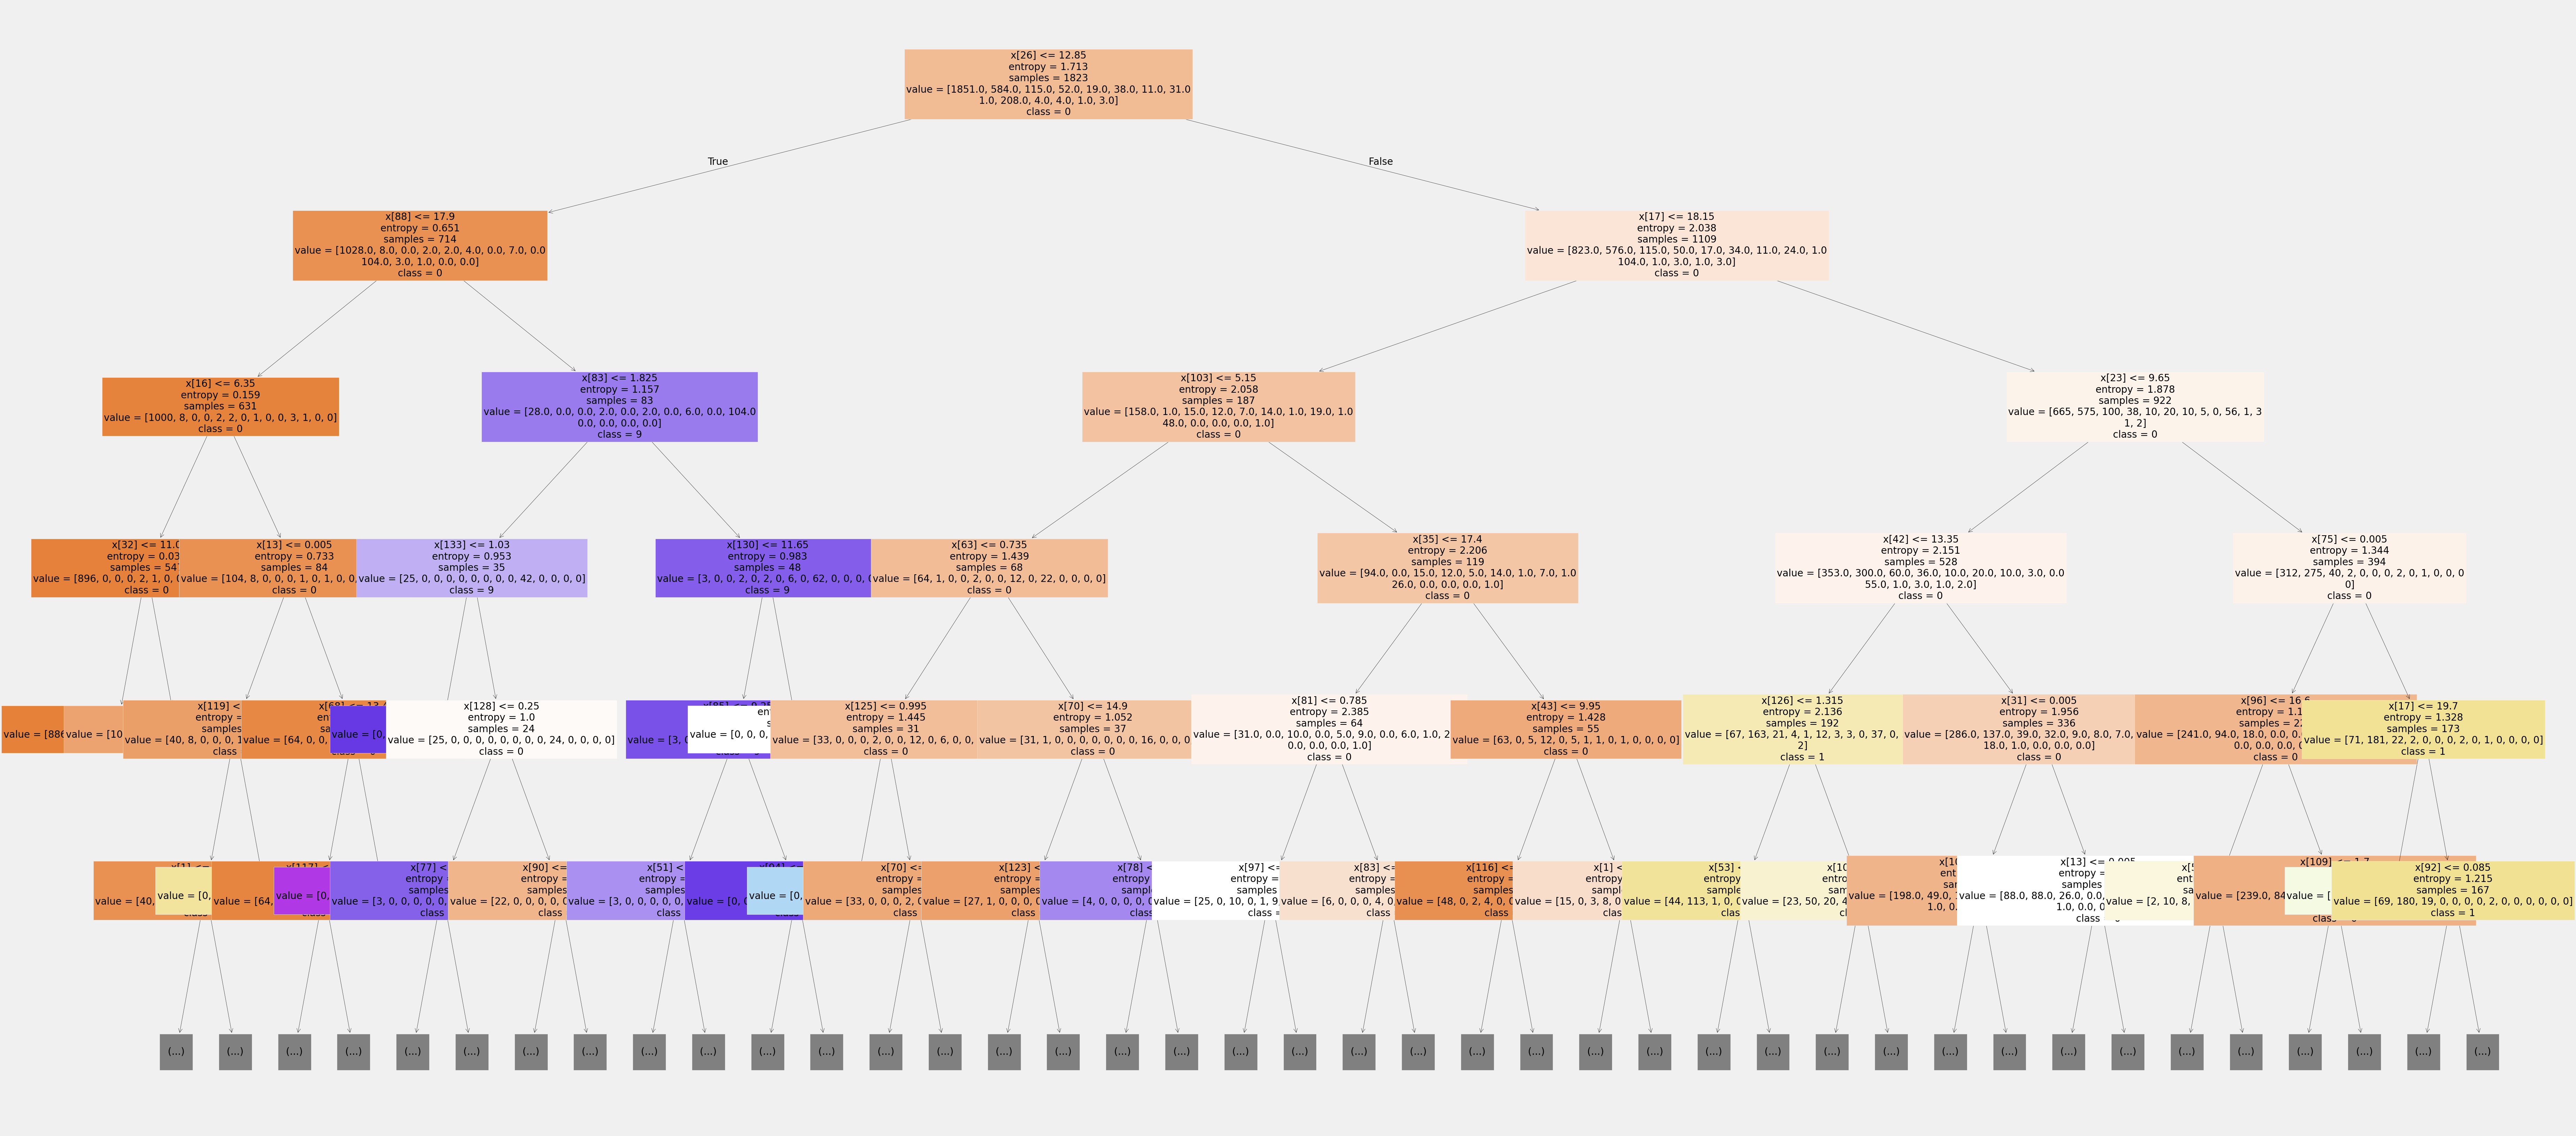

In [102]:
# Plotting decision tree 23
fig = plt.figure(figsize=(80,40))
plot_tree(clf2.estimators_[23], max_depth=5, fontsize = 20, class_names=[str(c) for c in clf2.classes_], filled=True)
# Saving
fig.savefig(f"{path}/Analysis/Visualizations/Optim_Decision_Tree23_.png")

# Feature importance

In [103]:
newarray = clf2.feature_importances_
newarray

array([0.00902101, 0.00930582, 0.00550802, 0.01366688, 0.06063055,
       0.01673112, 0.00958624, 0.00516996, 0.01696651, 0.00839281,
       0.01006421, 0.00565771, 0.01016106, 0.04734731, 0.01165605,
       0.02050954, 0.01289172, 0.03075378, 0.00400549, 0.00692301,
       0.005756  , 0.00884191, 0.01036404, 0.00776839, 0.01806051,
       0.0095347 , 0.01880715, 0.00161406, 0.00288095, 0.00594766,
       0.00561313, 0.00535034, 0.00323909, 0.0060383 , 0.00304149,
       0.01010703, 0.00250014, 0.00293516, 0.00641666, 0.00546366,
       0.00471574, 0.00345467, 0.00631759, 0.0036172 , 0.01193809,
       0.00155627, 0.00314557, 0.00432593, 0.00550522, 0.00254569,
       0.00281863, 0.00533272, 0.00370238, 0.00972416, 0.00315274,
       0.00771232, 0.00451318, 0.00426125, 0.00321173, 0.00819683,
       0.00579718, 0.00923805, 0.00241704, 0.00497877, 0.00642772,
       0.00649933, 0.00395541, 0.00568154, 0.01334691, 0.0066052 ,
       0.01622096, 0.0024995 , 0.00328047, 0.00618349, 0.00572

In [104]:
# Reshaping
newarray = newarray.reshape(-1,15,9)
print(newarray.shape)
newarray

(1, 15, 9)


array([[[0.00902101, 0.00930582, 0.00550802, 0.01366688, 0.06063055,
         0.01673112, 0.00958624, 0.00516996, 0.01696651],
        [0.00839281, 0.01006421, 0.00565771, 0.01016106, 0.04734731,
         0.01165605, 0.02050954, 0.01289172, 0.03075378],
        [0.00400549, 0.00692301, 0.005756  , 0.00884191, 0.01036404,
         0.00776839, 0.01806051, 0.0095347 , 0.01880715],
        [0.00161406, 0.00288095, 0.00594766, 0.00561313, 0.00535034,
         0.00323909, 0.0060383 , 0.00304149, 0.01010703],
        [0.00250014, 0.00293516, 0.00641666, 0.00546366, 0.00471574,
         0.00345467, 0.00631759, 0.0036172 , 0.01193809],
        [0.00155627, 0.00314557, 0.00432593, 0.00550522, 0.00254569,
         0.00281863, 0.00533272, 0.00370238, 0.00972416],
        [0.00315274, 0.00771232, 0.00451318, 0.00426125, 0.00321173,
         0.00819683, 0.00579718, 0.00923805, 0.00241704],
        [0.00497877, 0.00642772, 0.00649933, 0.00395541, 0.00568154,
         0.01334691, 0.0066052 , 0.0162209

In [105]:
sumarray = np.sum(newarray[0], axis=1)
print(sumarray.shape)
sumarray

(15,)


array([0.14658612, 0.15743419, 0.0900612 , 0.04383206, 0.0473589 ,
       0.03865658, 0.04850033, 0.06621535, 0.0507899 , 0.09011429,
       0.06269186, 0.0364136 , 0.04796143, 0.03523195, 0.03815226])

In [106]:
# Creating station name index
stations = (Weather_sub2.columns.str.split('_', n=1).str[0].unique().tolist())
print(len(stations))
print(stations)

15
['BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 'HEATHROW', 'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 'MUNCHENB', 'OSLO', 'SONNBLICK', 'STOCKHOLM', 'VALENTIA']


In [107]:
important = pd.Series(sumarray, index=stations).sort_values(ascending=False)
important

BELGRADE      0.157434
BASEL         0.146586
MADRID        0.090114
BUDAPEST      0.090061
LJUBLJANA     0.066215
MUNCHENB      0.062692
MAASTRICHT    0.050790
KASSEL        0.048500
SONNBLICK     0.047961
DUSSELDORF    0.047359
DEBILT        0.043832
HEATHROW      0.038657
VALENTIA      0.038152
OSLO          0.036414
STOCKHOLM     0.035232
dtype: float64

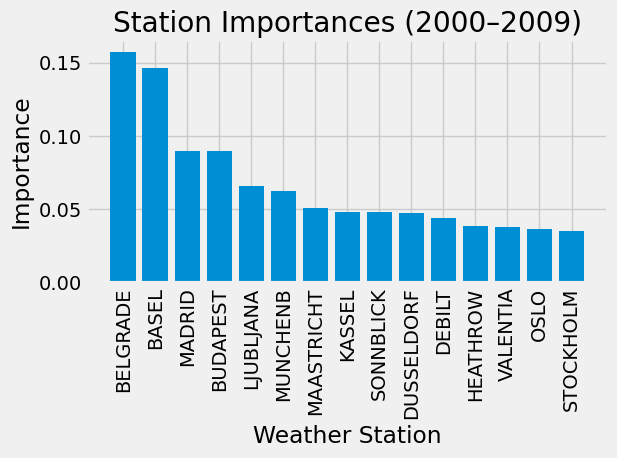

In [108]:
# Plotting weather stations importance
plt.style.use('fivethirtyeight')
x_values = range(len(important))
plt.bar(x_values, important.values)
plt.xticks(x_values, important.index, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Weather Station')
plt.title('Station Importances (2000–2009)')
plt.tight_layout()
# Saving
plt.savefig(f"{path}/Analysis/Visualizations/Optim_Station_Import_BarChart2000s.png")

# Subsetting to Belgrade weather station

In [110]:
# Subsetting Belgrade weather station
def subset_station(Weather2, station):
    station = station.lower()
    station_cols = [c for c in Weather2.columns if station in str(c).lower()]
    return Weather2[['DATE'] + station_cols].copy()

In [111]:
Belgrade_Weather2 = subset_station(Weather2, 'Belgrade')

In [112]:
# Dropping the 'DATE' column
Belgrade_Weather2 = Belgrade_Weather2.drop(columns=['DATE'], errors='ignore')

In [113]:
Belgrade_Weather2.columns

Index(['BELGRADE_cloud_cover', 'BELGRADE_humidity', 'BELGRADE_pressure',
       'BELGRADE_global_radiation', 'BELGRADE_precipitation',
       'BELGRADE_sunshine', 'BELGRADE_temp_mean', 'BELGRADE_temp_min',
       'BELGRADE_temp_max'],
      dtype='object')

In [114]:
# Creating a NumPy array for X
X = Belgrade_Weather2.to_numpy()
X.shape

(22950, 9)

# Subsetting the label data set

In [115]:
# Creating a NumPy array for y
y = Pleasant_weather.to_numpy()
y.shape

(22950, 16)

In [116]:
Pleasant_weather.columns

Index(['BASEL_pleasant_weather', 'BELGRADE_pleasant_weather',
       'BUDAPEST_pleasant_weather', 'DEBILT_pleasant_weather',
       'DUSSELDORF_pleasant_weather', 'HEATHROW_pleasant_weather',
       'KASSEL_pleasant_weather', 'LJUBLJANA_pleasant_weather',
       'MAASTRICHT_pleasant_weather', 'MADRID_pleasant_weather',
       'MUNCHENB_pleasant_weather', 'OSLO_pleasant_weather',
       'SONNBLICK_pleasant_weather', 'STOCKHOLM_pleasant_weather',
       'VALENTIA_pleasant_weather', 'DATE'],
      dtype='object')

In [117]:
Pleasant_weather = Pleasant_weather.drop(columns=['DATE'], errors='ignore')

In [118]:
y = Pleasant_weather.to_numpy()
y.shape

(22950, 15)

In [119]:
# Creating a NumPy array for y
y = Pleasant_weather['BELGRADE_pleasant_weather'].to_numpy().squeeze()
y.shape

(22950,)

In [120]:
# Splitting the data, while preserving the temporal aspect/dependancy by 'not shuffling'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# RANDOM SEARCH

In [129]:
# Creating a RF classifier
clf3 = RandomForestClassifier(random_state=43)

In [130]:
# Using scoring='accuracy'
start = time.time()
rf_random_acc = RandomizedSearchCV(clf3, rs_space, n_iter=100, scoring='accuracy', cv=tscv, n_jobs=-1, verbose=0, random_state=42)
model_random_acc = rf_random_acc.fit(X_train, y_train)
print(rf_random_acc.best_score_)
print('Search took %s minutes' % ((time.time() - start)/60))

1.0
Search took 1.2958187421162923 minutes


In [131]:
# Random search results
print('Best RANDOM search hyperparameters are: '+str(model_random_acc.best_params_))
print('Best RANDOM search score is: '+str(model_random_acc.best_score_))

Best RANDOM search hyperparameters are: {'criterion': 'gini', 'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 360}
Best RANDOM search score is: 1.0


In [132]:
pd.Series(y_train).value_counts()

0    12115
1     6245
Name: count, dtype: int64

In [136]:
# Creating a RF classifier with the best results from above
clf4 = RandomForestClassifier(criterion="gini", max_depth=40, max_features=5, min_samples_leaf=3, min_samples_split=6, n_estimators=360)

# Training the model on the training dataset
clf4.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, max_features=5, min_samples_leaf=3,
                       min_samples_split=6, n_estimators=360)

In [137]:
# Performing predictions on the test dataset
y_pred = clf4.predict(X_test)

In [138]:
# Using metrics module for accuracy calculation
print("Model Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Model Accuracy:  0.9997821350762527


# The model performs really well on the unseen data, with almost 100% accuracy

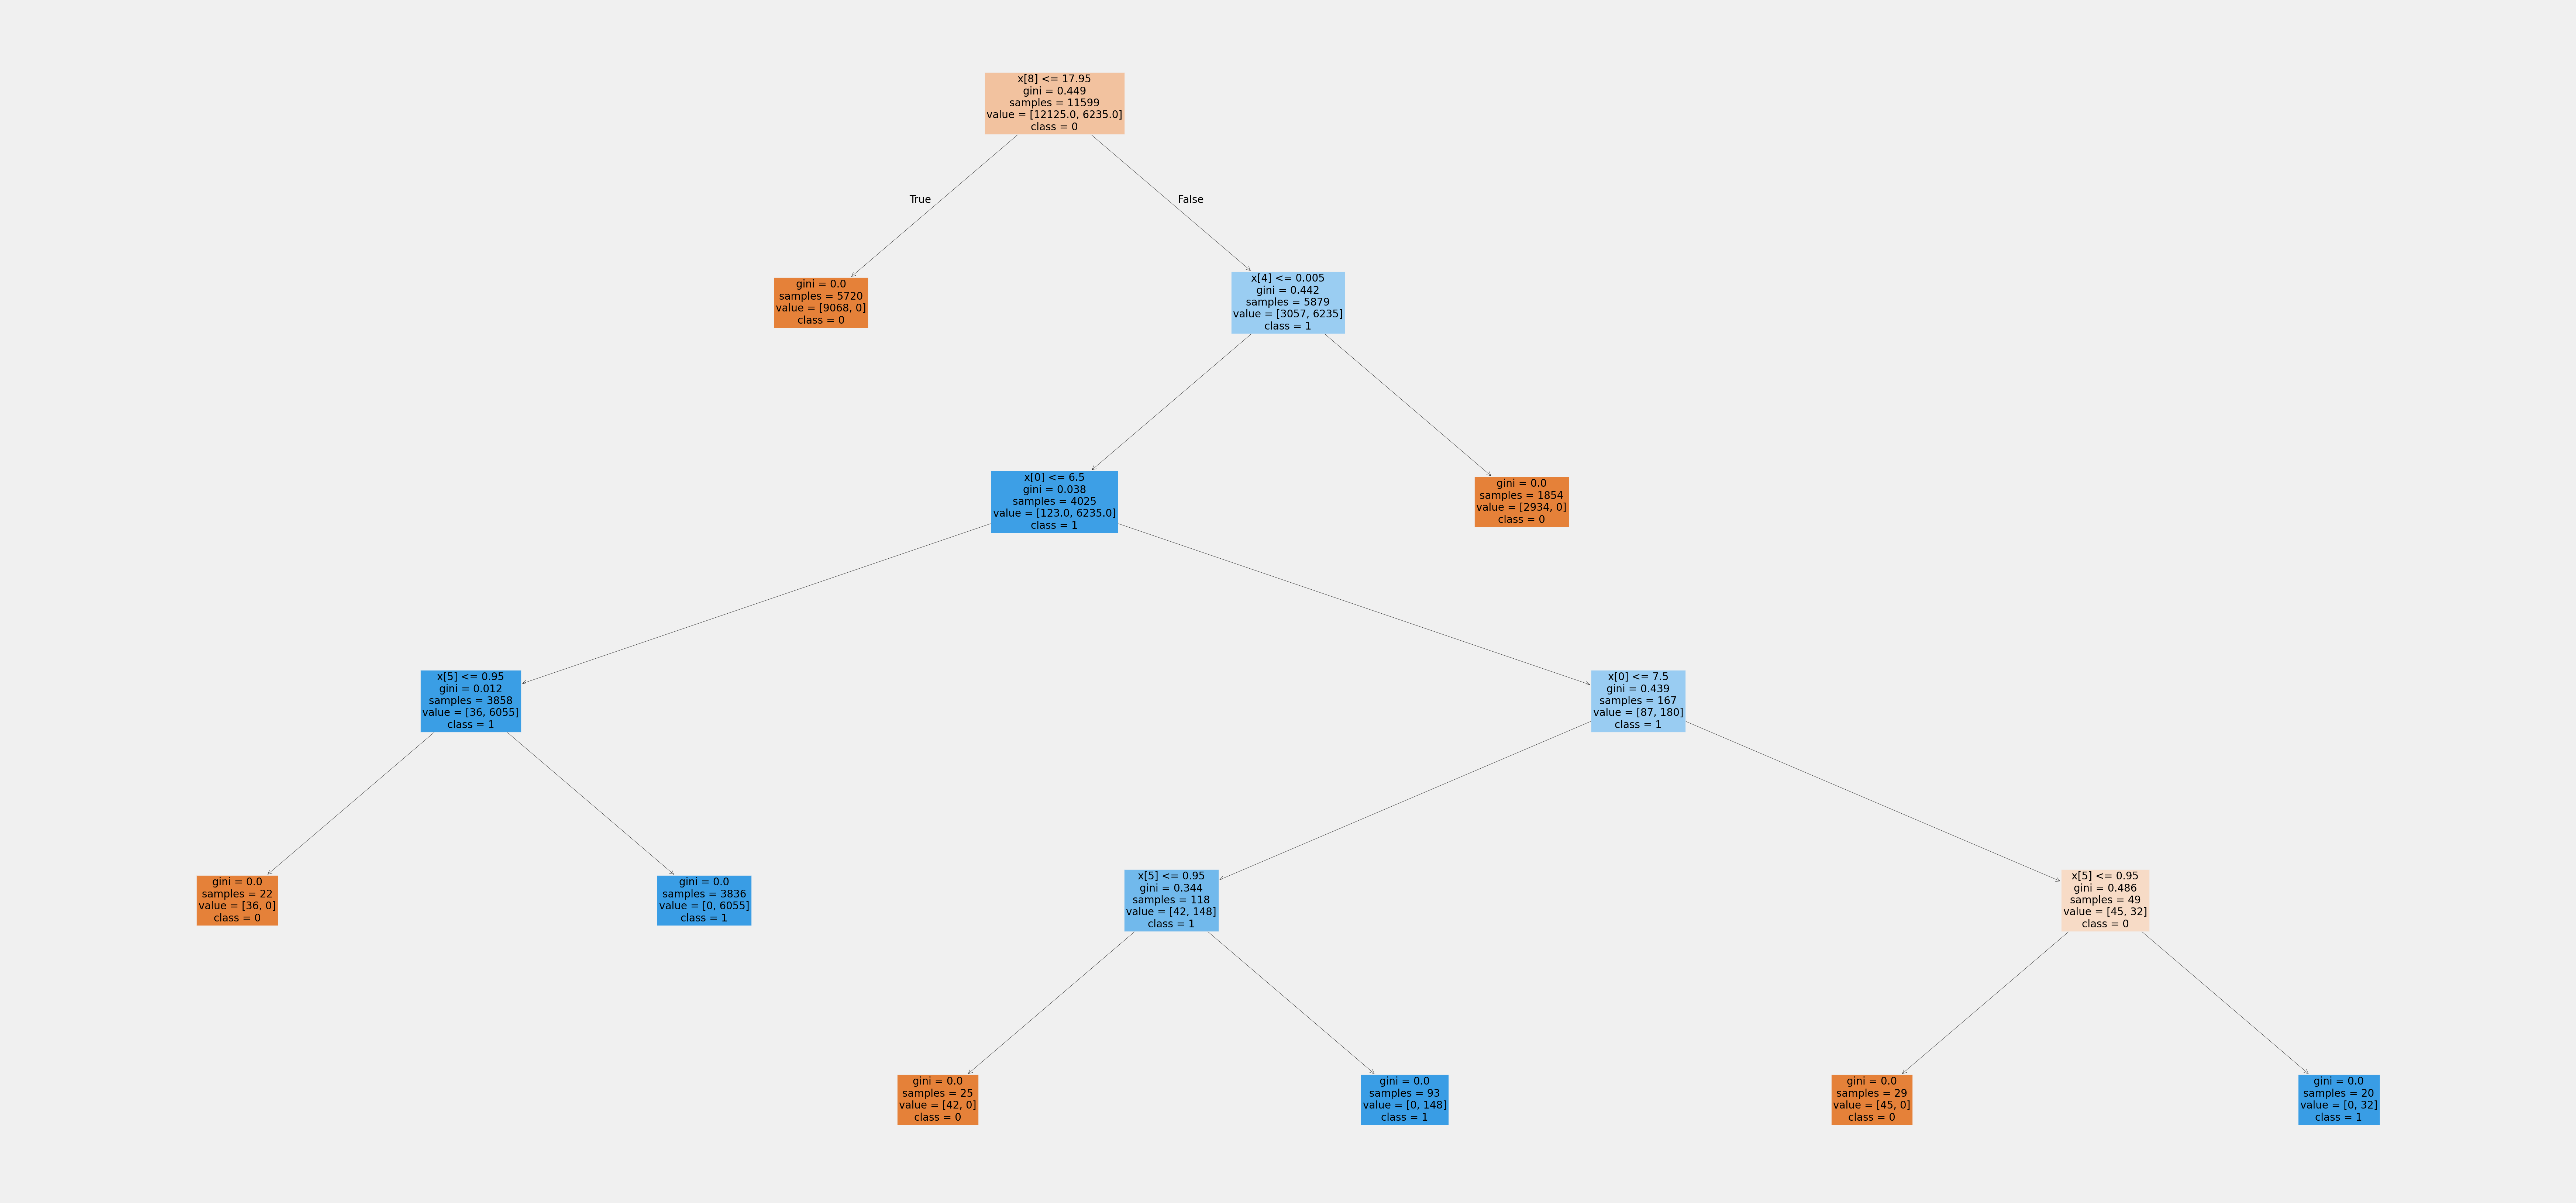

In [139]:
# Plotting decision tree 24
fig = plt.figure(figsize=(80,40))
plot_tree(clf4.estimators_[24], max_depth=5, fontsize = 20, class_names=[str(c) for c in clf4.classes_], filled=True)
# Saving
fig.savefig(f"{path}/Analysis/Visualizations/Optim_Decision_Tree24_.png")

# Feature importance

In [140]:
newarray = clf4.feature_importances_
newarray

array([0.04508858, 0.00449697, 0.00212057, 0.0378282 , 0.40028827,
       0.05449273, 0.11161905, 0.00262133, 0.3414443 ])

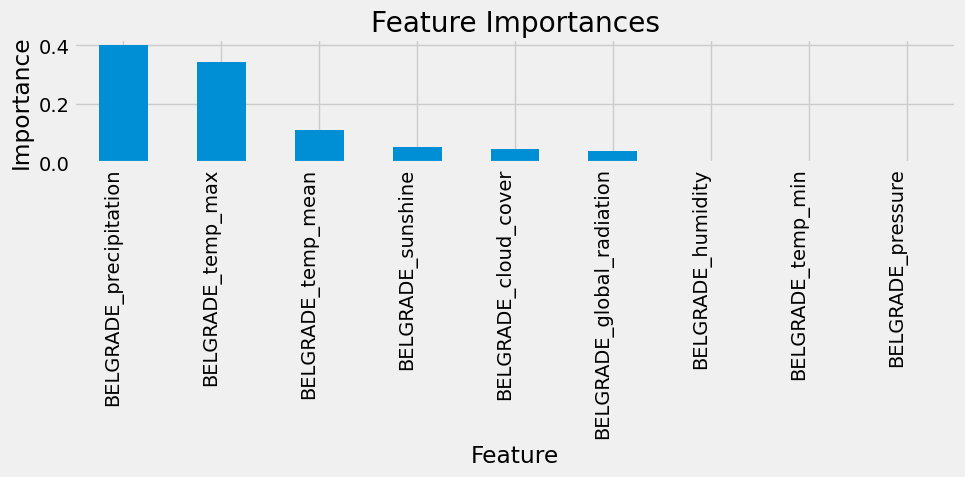

In [148]:
labels = Belgrade_Weather2.columns
important = pd.Series(newarray, index=labels).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10, 5))
important.plot(kind='bar', ax=ax)
ax.set_xticklabels(important.index, rotation=90, ha="right")
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")
ax.set_title("Feature Importances")
fig.tight_layout()
plt.savefig(f"{path}/Analysis/Visualizations/Optim_Belgrade_FeatImp.png")